# Google Play Store Data

We will predit the rating of a Google Play Store app as a function of its attributes. We get our data from this source: https://www.kaggle.com/lava18/google-play-store-apps

Our first step will be to import all of the modules we need, and then load the data.

In [1]:
import Pkg
Pkg.add("CSV")
# Pkg.add("Plots")
Pkg.add("DataFrames")
Pkg.add("Statistics")
Pkg.add("StatsPlots")
Pkg.add("Measures")
Pkg.add("LowRankModels")
include("proxgrad.jl")
Pkg.add("Dates")

using Random
Random.seed!(13)

using CSV
# using Plots
using DataFrames
using StatsPlots
using Statistics
using LinearAlgebra
using Measures
using LowRankModels
using Dates

   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.t

In [2]:
apps = CSV.read("googleplaystore.csv", pool=false)
names!(apps, Symbol.(replace.(string.(names(apps)), Ref(r"\s"=>"")))) #remove whitespace from column names
feature_names = names(apps)
for i in 1:13
    println(string(i), "\t", string(feature_names[i]), "\t\t\t", string(eltype(apps[!, i])))
end

thread = 1 warning: only found 12 / 13 columns around data row: 10474. Filling remaining columns with `missing`
thread = 1 warning: only found 12 / 13 columns around data row: 10474. Filling remaining columns with `missing`
1	App			String
2	Category			String
3	Rating			Float64
4	Reviews			String
5	Size			String
6	Installs			String
7	Type			String
8	Price			String
9	ContentRating			Union{Missing, String}
10	Genres			String
11	LastUpdated			String
12	CurrentVer			Union{Missing, String}
13	AndroidVer			Union{Missing, String}


# (A) Clean Data

In [3]:
#Clean Ratings column 

new_ratings = Float64[]
for idx=1:size(apps,1)
    if !isnan(apps[idx, :Rating])
        push!(new_ratings, apps[idx, :Rating])
    end
end 
        
for idx=1:size(apps,1)
    if isnan(apps[idx, :Rating])
        apps[idx, :Rating]=round(mean(new_ratings), digits=1)   #set NaN Rating values equal to the mean 
    end
end

In [4]:
#Clean Size column

"This function converts strings to floating point values.
Strings that cannot be represented as a number (like NA) are converted to zeros"
function string_to_float(str)
    try
        parse(Float64, str)
    catch
       0.0
    end
end

for idx=1:size(apps,1)
    apps[idx, :Size] = rstrip(apps[idx, :Size], 'M')
    if rstrip(apps[idx, :Size], 'k') != apps[idx, :Size]
        apps[idx, :Size] = string((round(string_to_float(rstrip(apps[idx, :Size], 'k'))/1000, digits=1)))
    end
    if lstrip(apps[idx, :Size], 'V') != apps[idx, :Size]
        apps[idx, :Size] = ""
    end
end

typeof(apps[:, :Size])

Array{String,1}

In [5]:
#Clean Installs column

for idx=1:size(apps,1)
    apps[idx, :Installs] = replace(rstrip(apps[idx, :Installs], '+'), "," => "")
end

print(unique(apps[:, :Installs]))

["10000", "500000", "5000000", "50000000", "100000", "50000", "1000000", "10000000", "5000", "100000000", "1000000000", "1000", "500000000", "50", "100", "500", "10", "1", "5", "0", "Free"]

In [6]:
#Clean Type column

apps = filter(row -> !(row.Type in ["NaN"]), apps);

for idx=1:size(apps,1)
    if apps[idx, :Type] == "0"
        apps[idx, :Type] = "Free"
    end
end 

typeof(apps[:, :Type])

Array{String,1}

In [7]:
#Clean Content Rating column 

new_content_ratings = String[]
for idx=1:size(apps,1)
    if ismissing(apps[idx, :ContentRating])
        push!(new_content_ratings, "Unrated")
    else
        push!(new_content_ratings, apps[idx, :ContentRating])
    end
end 

apps = select!(apps, Not(:ContentRating))
insert!(apps, 9, new_content_ratings, :ContentRating)
typeof(apps[:, :ContentRating])


Array{String,1}

In [8]:
#Clean Category column 

apps = filter(row -> !(row.Category in ["1.9"]), apps);

# (B) Train/Test Split

To make the 80 / 20 train test split, we are going to shuffle the data, and then select the first 80%
  as the train data, with 20%
  held out for validation.

In [9]:
feature_names = names(apps)

apps = apps[shuffle(1:end), :] # we shuffle the data so that our train/test split will be truly random

train_proportion = 0.8
n = size(apps, 1)
println("Size of dataset: ", string(n))

# Put the first ntrain observations in the DataFrame df into the training set, and the rest into the test set
ntrain = convert(Int, round(train_proportion*n))
ntest = n-ntrain

target = apps[:, :Rating]
data = apps[:, filter(col -> (col != :Rating), feature_names)]

# the following variable records the features of examples in the training set
train_x = data[1:ntrain,:]
# the following variable records the features of examples in the test set
test_x = data[ntrain+1:n,:]
# the following variable records the labels of examples in the training set
train_y = target[1:ntrain,1]
# the following variable records the labels of examples in the test set
test_y = target[ntrain+1:n,1]

Size of dataset: 10839


2168-element Array{Float64,1}:
 4.5
 3.9
 4.3
 3.4
 4.0
 3.7
 4.2
 4.5
 3.5
 4.2
 4.6
 3.6
 4.3
 ⋮
 4.2
 4.1
 3.9
 3.8
 4.4
 3.8
 4.3
 5.0
 4.7
 4.3
 4.2
 4.3

In [10]:
labels_real = [
    :Reviews,
    :Size,
    :Installs
]

3-element Array{Symbol,1}:
 :Reviews
 :Size
 :Installs

In [11]:
train_vals_real = convert(Matrix, string_to_float.(train_x[:, labels_real]))
test_vals_real = convert(Matrix, string_to_float.(test_x[:, labels_real]))

train_vals_real = hcat(train_vals_real, ones(ntrain, 1))
test_vals_real = hcat(test_vals_real, ones(ntest, 1))

2168×4 Array{Float64,2}:
  73539.0  96.0       1.0e6  1.0
  28429.0  14.0       5.0e6  1.0
 192374.0  56.0       1.0e7  1.0
     30.0   3.0   10000.0    1.0
   4332.0  12.0       1.0e6  1.0
    166.0   2.0    5000.0    1.0
      0.0   3.4      50.0    1.0
 212626.0  11.0       1.0e7  1.0
  14823.0  40.0       1.0e6  1.0
  67772.0   0.0       5.0e6  1.0
    603.0   7.4   10000.0    1.0
   5692.0  31.0       1.0e6  1.0
    176.0   2.3  100000.0    1.0
      ⋮                      
      5.0  44.0     500.0    1.0
    331.0  10.0   50000.0    1.0
  60841.0   0.0       5.0e6  1.0
    103.0   6.9    5000.0    1.0
  12683.0  19.0       1.0e6  1.0
   1093.0   0.0  100000.0    1.0
  32584.0   0.0       1.0e6  1.0
      9.0   1.5     100.0    1.0
  20001.0   0.0       1.0e6  1.0
     33.0  46.0    1000.0    1.0
     10.0   3.0     500.0    1.0
   4551.0  79.0  500000.0    1.0

In [12]:
"""This function just computes the mean squared error."""
function MSE(y, pred)
    return mean((y .- pred) .^ 2)
end

MSE

In [13]:
"""This function plots the main diagonal;
for a "predicted vs true" plot with perfect predictions,
all data lies on this line"""
function plotDiagonal(xmin, xmax)
    xsamples = [xmin, xmax]
    plot!(xsamples, xsamples, color=:black)
end

plotDiagonal

In [14]:
"""This helper funciton plots x vs, y and labels the axes."""
function plotdata(x,y,xname, yname, title; margin=0.05, plotDiag=true, zeromin=false)
    theme(:default)
    scatter(x,y, label="data", title=title, legend=:topleft)
    xlabel!(xname)
    ylabel!(yname)
    range_y = maximum(y) - minimum(y)
    range_x = maximum(x) - minimum(x)
    if plotDiag
        plotDiagonal(minimum(x)-margin*range_x, maximum(x)+margin*range_x)
    end
    if zeromin
        ylims!((0.0,maximum(y)+margin*range_y))
        xlims!((0.0,maximum(x)+margin*range_x))
    else
        ylims!((minimum(y)-margin*range_y,maximum(y)+margin*range_y))
        xlims!((minimum(x)-margin*range_x,maximum(x)+margin*range_x))
    end
end

plotdata

In [15]:
"""This function plots the predicted labels vs the actual labels
(We only plots the first 1000 points to avoid slow plots.)"""
function plot_pred_true(test_pred, test_y, title, max_points = 1000)
    plotdata(test_pred[1:max_points], test_y[1:max_points], "Predicted Rating", "True Rating", title, zeromin=true)
end

plot_pred_true

In [16]:
# The weights of your linear equation (compute via least squares)
w = train_vals_real \ train_y

#Your prediction vectors
train_pred = [sum(w.*train_vals_real[i, :]) for i=1:size(train_vals_real, 1)] 
test_pred = [sum(w.*test_vals_real[i, :]) for i=1:size(test_vals_real, 1)] 

total = 0 
overone = 0 
for i=1:length(train_pred)
    error = (train_pred[i] - train_y[i])^2
    total += error
    if error > 1
        overone += 1 
    end
end

# println(total)
# println(overone)

#The mean squared error for your predictions.
train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

0.23329568860039016

Train MSE	0.22661988818515005
Test MSE 	0.23329568860039016


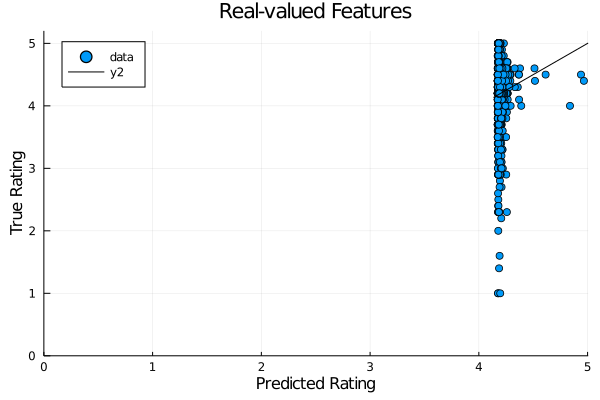

In [17]:
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "Real-valued Features")

# (C) One-Hot Encoding

In [18]:
# Create one hot encoding for category-type columns 

cat_labels = [
    :Category,
    :Type,
    :ContentRating
]

#Sets of all categories in a particular column
cats_sets = [unique(train_x[:, label]) for label in cat_labels]

3-element Array{Array{String,1},1}:
 ["PHOTOGRAPHY", "LIBRARIES_AND_DEMO", "MEDICAL", "LIFESTYLE", "BUSINESS", "GAME", "TOOLS", "FAMILY", "FINANCE", "NEWS_AND_MAGAZINES"  …  "SPORTS", "EVENTS", "EDUCATION", "WEATHER", "FOOD_AND_DRINK", "ENTERTAINMENT", "BOOKS_AND_REFERENCE", "BEAUTY", "MAPS_AND_NAVIGATION", "PARENTING"]
 ["Paid", "Free"]
 ["Everyone", "Teen", "Everyone 10+", "Mature 17+", "Adults only 18+", "Unrated"]

In [19]:
"Computes a onehot vector for every entry in column given a set of categories cats"
function onehot(column, cats=unique(column))
    n = size(column,1) 
    d = size(cats,1) 
    result = zeros(n, d)
    for i = 1:n 
        for j=1:d
            if column[i] == cats[j] 
                result[i, j] = 1
            end 
        end
    end
    return result
end

onehot

In [20]:
category_onehot = onehot(train_x[:, :Category], cats_sets[1])

8671×33 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [21]:
type_onehot = onehot(train_x[:, :Type], cats_sets[2])

8671×2 Array{Float64,2}:
 1.0  0.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 ⋮    
 0.0  1.0
 1.0  0.0
 1.0  0.0
 0.0  1.0
 1.0  0.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0
 0.0  1.0

In [22]:
content_rating_onehot = onehot(train_x[:, :ContentRating], cats_sets[3])

8671×6 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0

In [23]:
train_cat_vals = hcat([onehot(train_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...)
test_cat_vals = hcat([onehot(test_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...) 

2168×41 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  1.0  0.0  0.0  0.0  1.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     1.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     1.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [24]:
train_vals = hcat(train_cat_vals, train_vals_real)
test_vals = hcat(test_cat_vals, test_vals_real)

w = train_vals \ train_y 

train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
        
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "Real-valued + One-hot Features")
png("OneHot")

Train MSE	0.22012219576797956
Test MSE 	0.23091872436297095


# (D) Many-Hot Encoding

In [25]:
print(train_x[1:100, :Genres])

["Photography", "Libraries & Demo", "Medical", "Lifestyle", "Business", "Medical", "Racing", "Photography", "Tools", "Education", "Finance", "Business", "News & Magazines", "Shopping", "News & Magazines", "Tools", "Social", "Tools", "Puzzle", "Travel & Local", "Education", "House & Home", "Casual;Action & Adventure", "Productivity", "Video Players & Editors", "Education;Pretend Play", "Medical", "Health & Fitness", "Finance", "Business", "Casual", "Communication", "Medical", "House & Home", "Medical", "Personalization", "Dating", "News & Magazines", "Art & Design", "Auto & Vehicles", "Music", "Medical", "Tools", "Travel & Local", "Business", "Health & Fitness", "Education", "Dating", "Arcade", "Education", "Entertainment", "Communication", "Comics", "News & Magazines", "Business", "Personalization", "Photography", "Business", "Lifestyle", "Personalization", "Lifestyle", "Productivity", "Lifestyle", "Lifestyle", "Finance", "Shopping", "News & Magazines", "Communication", "Productivity",

In [26]:
split_genres(x) = split(x, ";")
example_genres = split_genres(train_x[4, :Genres])

1-element Array{SubString{String},1}:
 "Lifestyle"

In [27]:
genres_train = split_genres.(train_x[:, :Genres])
genres_test = split_genres.(test_x[:, :Genres])

2168-element Array{Array{SubString{String},1},1}:
 ["Role Playing"]
 ["Photography"]
 ["Racing"]
 ["Photography"]
 ["News & Magazines"]
 ["Communication"]
 ["Medical"]
 ["Dating"]
 ["Action"]
 ["Weather"]
 ["Books & Reference"]
 ["Video Players & Editors"]
 ["Productivity"]
 ⋮
 ["Education"]
 ["Shopping"]
 ["Entertainment"]
 ["Finance"]
 ["Action"]
 ["News & Magazines"]
 ["Business"]
 ["Tools"]
 ["Weather"]
 ["Tools"]
 ["Entertainment"]
 ["Simulation"]

In [28]:
genre_types = unique(vcat(genres_train...))

53-element Array{SubString{String},1}:
 "Photography"
 "Libraries & Demo"
 "Medical"
 "Lifestyle"
 "Business"
 "Racing"
 "Tools"
 "Education"
 "Finance"
 "News & Magazines"
 "Shopping"
 "Social"
 "Puzzle"
 ⋮
 "Board"
 "Brain Games"
 "Creativity"
 "Beauty"
 "Casino"
 "Trivia"
 "Strategy"
 "Maps & Navigation"
 "Word"
 "Parenting"
 "Educational"
 "Music & Audio"

In [29]:
"Computes a manyhot vector for every entry in an array of arrays given a set of categories cats"
function manyhot(column, cats=unique(col))
    n = size(column, 1)
    d = size(cats, 1)
    result = zeros(n, d)
    
    for i = 1:n
        set_of_descriptions = column[i]
        for j = 1:d 
            if cats[j] in set_of_descriptions
                result[i, j] = 1 
            end
        end
    end 
    result
end

manyhot

In [30]:
genre_vals_train = manyhot(genres_train, genre_types)
genre_vals_test = manyhot(genres_test, genre_types)

two = 0 
for i=1:size(genre_vals_train, 1)
    total = sum(genre_vals_train[i, :])
    if total > 1
        two += 1
    end
end
println(two)
println(size(genre_vals_train, 1) - two)
println((size(genre_vals_train, 1) - two)/(two + size(genre_vals_train, 1)))

365
8306
0.919212040725985


Train MSE	0.21807514757106583
Test MSE 	0.22873714589748045


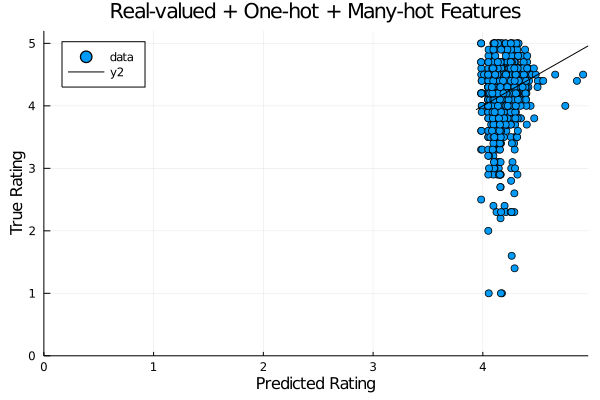

In [31]:
train_vals = hcat(genre_vals_train, train_vals)
test_vals = hcat(genre_vals_test, test_vals)

w = train_vals \ train_y

train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
    
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "Real-valued + One-hot + Many-hot Features")

# (E) Data Exploration

### Ratings

In [32]:
println(mean(apps[:, :Rating]))
println(minimum(apps[:, :Rating]))
println(maximum(apps[:, :Rating]))
median(apps[:, :Rating])

4.192877571731708
1.0
5.0


4.2

In [33]:
@df apps density(:Rating, xlabel="App Rating", ylabel="Frequency", legend=false)
png("RatingDensity")

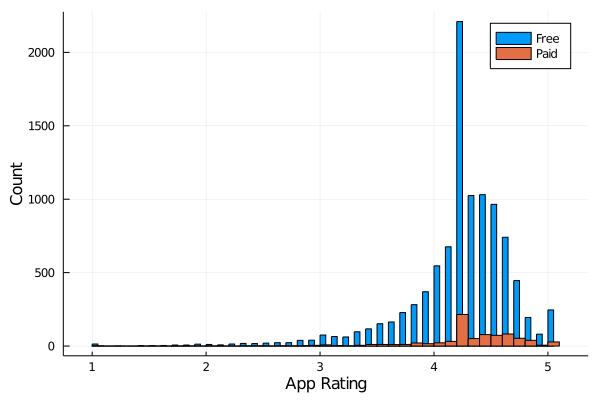

In [34]:
@df apps histogram(:Rating, group=:Type, xlabel="App Rating", ylabel="Count")

### Category

In [35]:
category_count = [] 
for idx=1:size(category_onehot,2)
    push!(category_count, sum(category_onehot[:, idx]))
end 
print(category_count)

Any[276.0, 69.0, 375.0, 301.0, 366.0, 927.0, 685.0, 1563.0, 297.0, 218.0, 203.0, 240.0, 212.0, 70.0, 339.0, 145.0, 264.0, 303.0, 319.0, 186.0, 50.0, 71.0, 52.0, 302.0, 52.0, 134.0, 57.0, 96.0, 120.0, 182.0, 42.0, 102.0, 53.0]

In [36]:
bar(category_count, xticks = (1:33, cats_sets[1]), xrotation=70, margin=10mm, legend=false, xlabel="Categories", ylabel="Count")
plot!(size=(700,600))
png("CategoryCount")


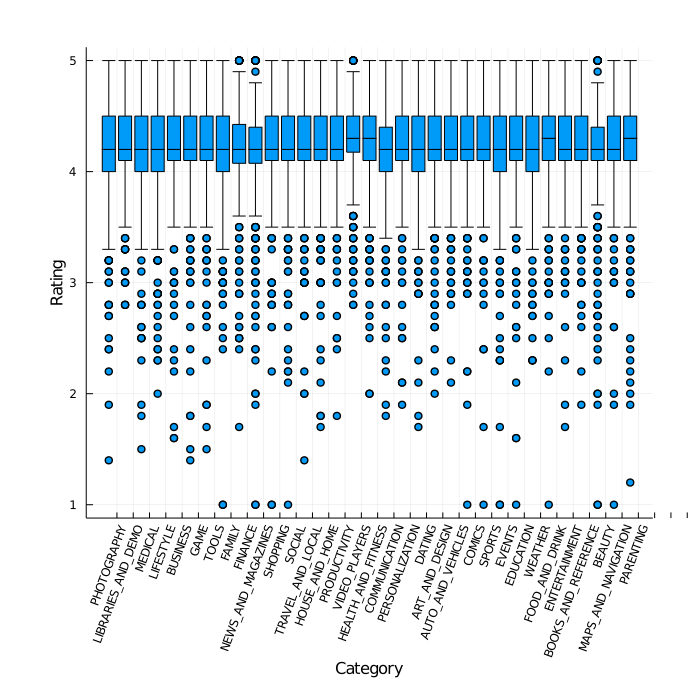

In [37]:
@df apps boxplot(cats_sets[1], :Rating, legend=false, xrotation=70, margin=10mm, xticks = (1:53, cats_sets[1]), 
    xlabel="Category", ylabel="Rating")
plot!(size=(700,700))

### Reviews

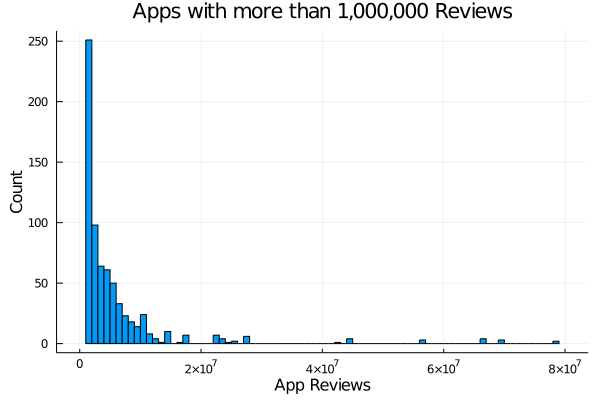

In [38]:
reviews_fl = transform(apps, :Reviews => ByRow(x -> string_to_float(x)) => :Reviews)
reviews_float = filter(row -> (row.Reviews > 1000000), reviews_fl); 
@df reviews_float histogram(:Reviews, xlabel="App Reviews", ylabel="Count", title="Apps with more than 1,000,000 Reviews", legend=false)

In [39]:
println(mean(reviews_fl[:, :Reviews]))
println(minimum(reviews_fl[:, :Reviews]))
println(maximum(reviews_fl[:, :Reviews]))
median(reviews_fl[:, :Reviews])

444193.87332779774
0.0
7.8158306e7


2094.0

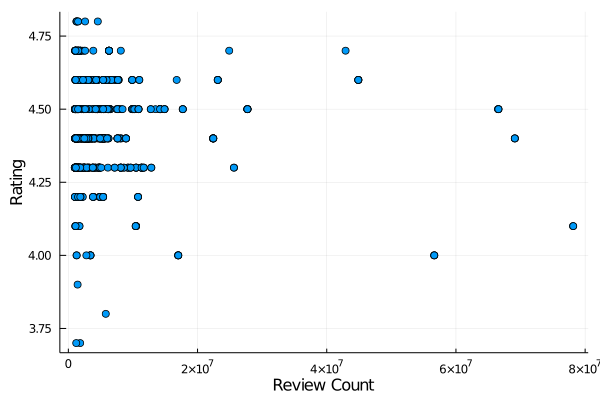

In [40]:
@df reviews_float scatter(:Reviews, :Rating, xlabel="Review Count", ylabel="Rating", legend=false)

### Size

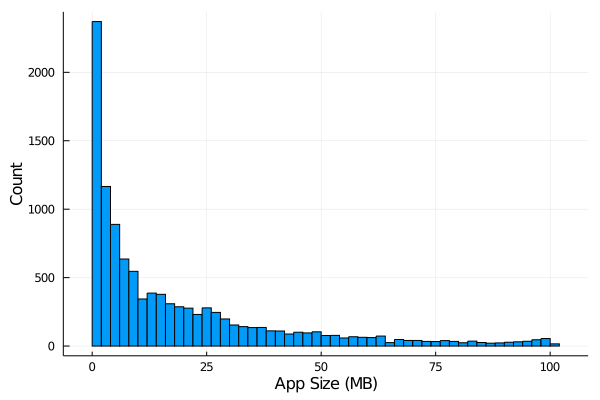

In [41]:
size_float = transform(apps, :Size => ByRow(x -> string_to_float(x)) => :Size)
@df size_float histogram(:Size, xlabel="App Size (MB)", ylabel="Count", legend=false)

In [42]:
println(mean(size_float[:, :Size]))
println(minimum(size_float[:, :Size]))
println(maximum(size_float[:, :Size]))
median(size_float[:, :Size])

18.153787249746284
0.0
100.0


9.2

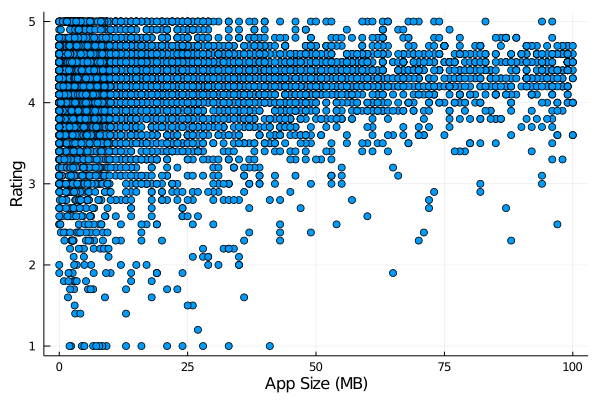

In [43]:
@df size_float scatter(:Size, :Rating, xlabel="App Size (MB)", ylabel="Rating", legend=false)

### Type and Installs

In [44]:
type_count = [] 
for idx=1:size(type_onehot,2)
    push!(type_count, sum(type_onehot[:, idx]))
end 
print(type_count)
646/(8025.0+646)


Any[646.0, 8025.0]

0.07450121093299504

In [45]:
8025/(8025.0+646)

0.925498789067005

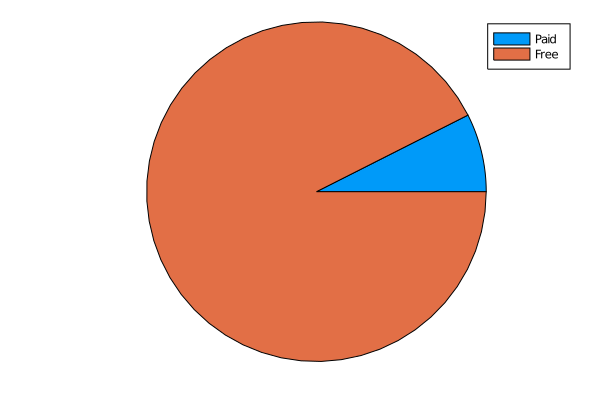

In [46]:
pie(cats_sets[2], type_count)

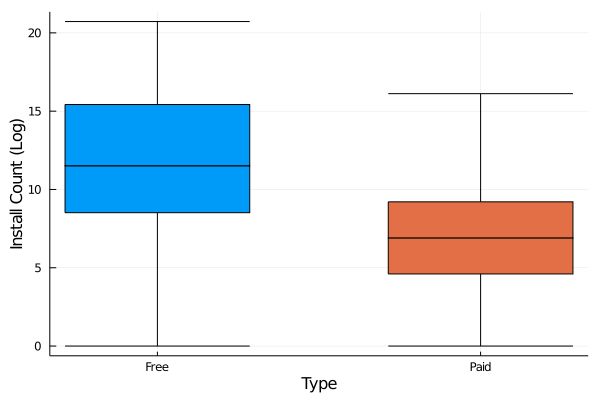

In [47]:
apps = filter(row -> !(row.Installs in ["NaN"]), apps);
installs_fl = transform(apps, :Installs => ByRow(x -> string_to_float(x)) => :Installs)
installs_float = filter(row -> !(row.Installs in [0]), installs_fl); # log(0) is undefined. 
installs_log = transform(installs_float, :Installs => ByRow(x -> log(x)) => :Installs)
@df installs_log boxplot(:Type, :Installs, group=:Type, legend=false, xlabel="Type", ylabel="Install Count (Log)")

1.5465765613709752e7
0.0
1.0e9


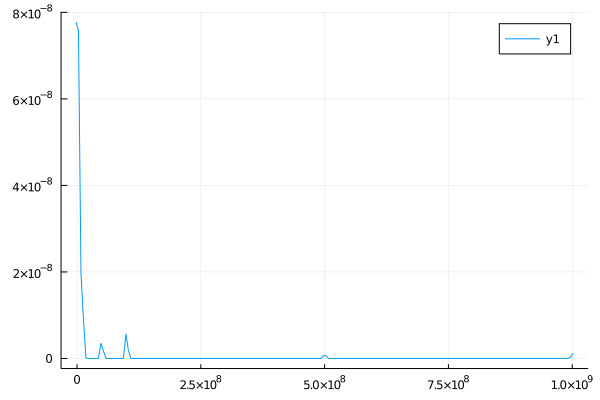

In [48]:
println(mean(installs_fl[:, :Installs]))
println(minimum(installs_fl[:, :Installs]))
println(maximum(installs_fl[:, :Installs]))
median(installs_fl[:, :Installs])

@df installs_fl density(:Installs)

### Price

In [49]:
paid_apps = filter(row -> !(row.Type in ["Free"]), apps);

price_float = Float64[]
for i=1:size(paid_apps, 1)
    price = replace(paid_apps[i, :Price], "\$" => "")
    push!(price_float, string_to_float(price))
end

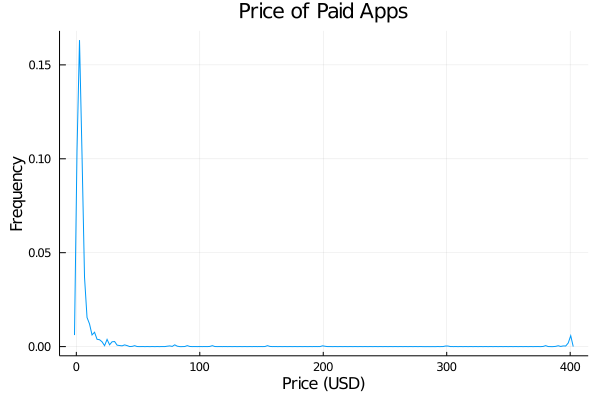

In [50]:
density(price_float, label=false, title="Price of Paid Apps", xlabel="Price (USD)", ylabel="Frequency")

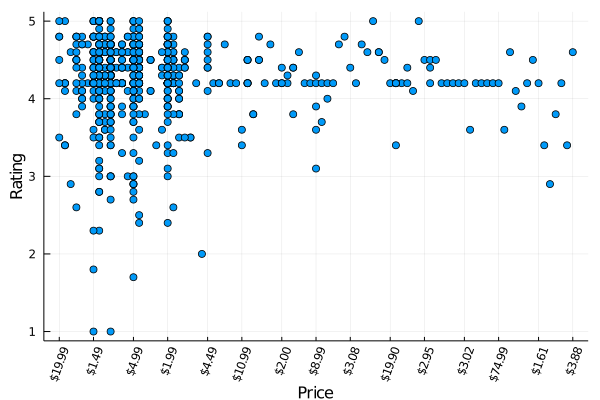

In [51]:
scatter(paid_apps[:, :Price], paid_apps[:, :Rating], xlabel="Price", ylabel="Rating", legend=false, xrotation=70)

### Content Rating

In [52]:
content_count = [] 
for idx=1:size(content_rating_onehot,2)
    push!(content_count, sum(content_rating_onehot[:, idx]))
end 

println(sum(content_count))
print(content_count./sum(content_count))

8671.0
[0.8046361434667282, 0.11082920078422327, 0.0390958366970361, 0.044977511244377814, 0.0002306539038173221, 0.0002306539038173221]

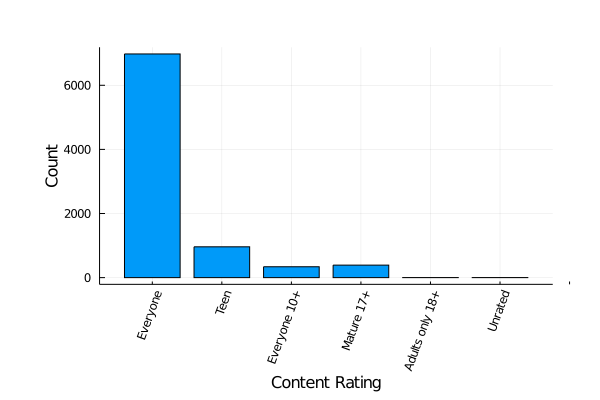

In [53]:
bar(content_count, xticks = (1:33, cats_sets[3]), xrotation=70, margin=10mm, legend=false, xlabel="Content Rating", ylabel="Count")
# plot!(size=(700,600))

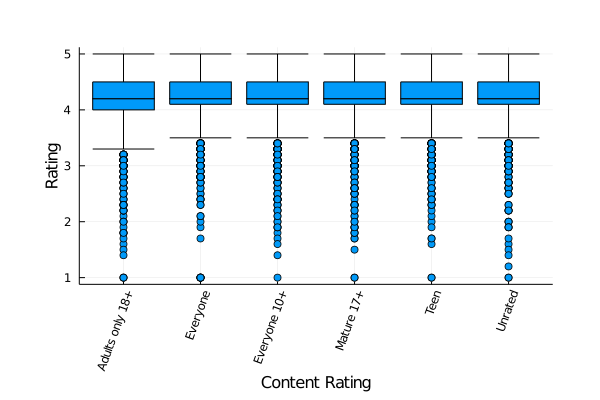

In [54]:
@df apps boxplot(cats_sets[3], :Rating, legend=false, xrotation=70, margin=10mm, 
    xlabel="Content Rating", ylabel="Rating")
# plot!(size=(700,700))

In [55]:
# Correlation between columns? Check for built in function. 
real_vals = transform(size_float, :Installs => ByRow(x -> string_to_float(x)) => :Installs);
real_vals = transform(real_vals, :Reviews => ByRow(x -> string_to_float(x)) => :Reviews);
real_vals = transform(real_vals, :Price => ByRow(x -> replace(x, "\$" => "")) => :Price)
real_vals = transform(real_vals, :Price => ByRow(x -> string_to_float(x)) => :Price);

In [80]:
@df real_vals corrplot([:Rating :Size :Installs :Reviews :Price], grid=false);

In [57]:
correlation = @df real_vals cor([:Rating :Reviews :Size :Installs :Price])

5×5 Array{Float64,2}:
  1.0         0.067662     0.0436581    0.0507947   -0.0201273
  0.067662    1.0          0.0654481    0.643121    -0.00966818
  0.0436581   0.0654481    1.0         -0.00347054  -0.0134584
  0.0507947   0.643121    -0.00347054   1.0         -0.0116906
 -0.0201273  -0.00966818  -0.0134584   -0.0116906    1.0

In [58]:
correlation_labels = correlation
for i=1:5
    for j=1:5
        correlation_labels[i, j] = round(correlation[i, j], digits=4)
    end
end

In [59]:
theme(:sand)
labels = ["Rating", "Reviews", "Size", "Installs", "Price"]
heatmap(labels, labels, correlation, yflip=true)
annotate!(vec(tuple.((1:length(labels))'.-0.5, (1:length(labels)).-0.5, string.(correlation_labels), 10)))
png("CorrelationPlot")
# annotate!(correlation)

# (F) Text Data

### Last Updated Column

In [73]:
# Convert lastUpdated column from string to type date
apps_date = Dates.Date.(apps[:, :LastUpdated], "U d, y");

In [74]:
# Convert type date to numerical value (Int64)
apps_date_real = Dates.datetime2rata.(apps_date);

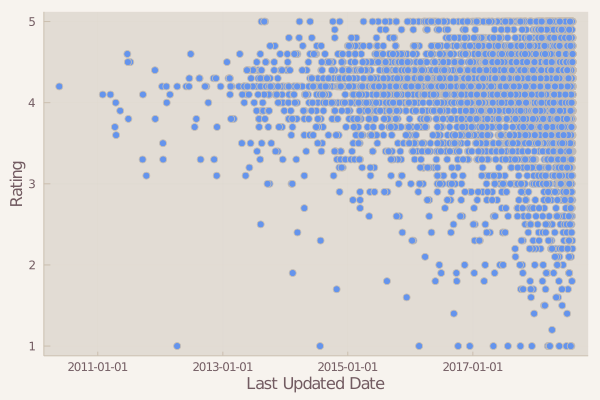

In [78]:
# Plot LastUpdated vs Rating
scatter(apps_date, apps[:, :Rating], xlabel="Last Updated Date", ylabel="Rating", legend=false)

In [81]:
# Convert LastUpdated column for training and testing data to numerical value 
date_train = Dates.Date.(train_x[:, :LastUpdated], "U d, y");
date_test = Dates.Date.(test_x[:, :LastUpdated], "U d, y");

In [82]:
# Next convert type date to numerical value (Int64)
lastUpdated_train = Dates.datetime2rata.(date_train);
lastUpdated_test = Dates.datetime2rata.(date_test); 

Train MSE	0.2139510399518327
Test MSE 	0.22456568523545706


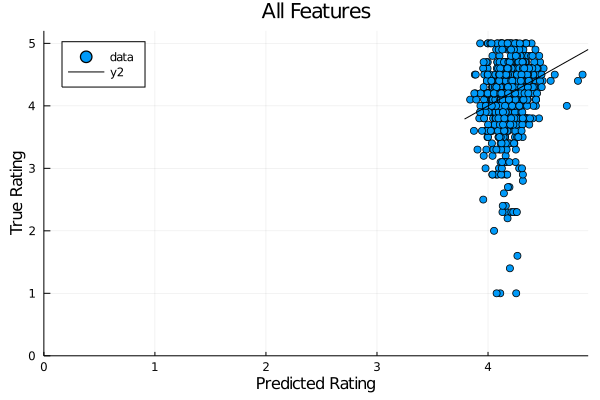

In [84]:
train_vals = hcat(lastUpdated_train, train_vals)
test_vals = hcat(lastUpdated_test, test_vals)

w = train_vals \ train_y

train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
    
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "All Features")

### User Reviews

In [86]:
reviews = CSV.read("googleplaystore_user_reviews.csv", pool=false)
names!(reviews, Symbol.(replace.(string.(names(reviews)), Ref(r"\s"=>"")))) #remove whitespace from column names
feature_names = names(reviews)
for i in 1:5
    println(string(i), "\t", string(feature_names[i]), "\t\t\t", string(eltype(apps[!, i])))
end

1	App			String
2	Translated_Review			String
3	Sentiment			Float64
4	Sentiment_Polarity			String
5	Sentiment_Subjectivity			String


In [87]:
# reviews = filter(row -> (row.App in [apps[1, :App]]), reviews)
# reviews = filter(row -> !(row.Translated_Review ), reviews)

In [88]:
# print("Number of apps with reviews: ", length(unique(reviews[:, :App])))

# (G) Feature Modeling

Let's compare predict rating with each feature individually to see which has the lowest error and explore that feature more closely.

### Category

In [115]:
train_vals = hcat(onehot(train_x[:, :Category], cats_sets[1]), ones(ntrain, 1))
test_vals = hcat(onehot(test_x[:, :Category], cats_sets[1]), ones(ntest, 1))

w = train_vals \ train_y

train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
    
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

Train MSE	0.22152556651167396
Test MSE 	0.23138910669787674


### Reviews

In [116]:
train_vals = hcat(train_vals_real[:, 1], ones(ntrain, 1))
test_vals = hcat(test_vals_real[:, 1], ones(ntest, 1))

w = train_vals \ train_y

train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
    
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

Train MSE	0.22708441250060776
Test MSE 	0.23336676971929643


### Size

In [117]:
train_vals = hcat(train_vals_real[:, 2], ones(ntrain, 1))
test_vals = hcat(test_vals_real[:, 2], ones(ntest, 1))

w = train_vals \ train_y

train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
    
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

Train MSE	0.22771117483250775
Test MSE 	0.23386631543892958


### Installs

In [118]:
train_vals = hcat(train_vals_real[:, 3], ones(ntrain, 1))
test_vals = hcat(test_vals_real[:, 3], ones(ntest, 1))

w = train_vals \ train_y

train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
    
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

Train MSE	0.2276716110440423
Test MSE 	0.23323257166779615


### Type

In [114]:
train_vals = hcat(onehot(train_x[:, :Type], cats_sets[2]), ones(ntrain, 1))
test_vals = hcat(onehot(test_x[:, :Type], cats_sets[2]), ones(ntest, 1))

w = train_vals \ train_y

train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
    
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

Train MSE	0.22797803045735202
Test MSE 	0.23411193225656488


### Price

In [107]:
# train_vals = hcat(onehot(train_x[:, :Category], cats_sets[1]), ones(ntrain, 1))
# test_vals = hcat(onehot(test_x[:, :Category], cats_sets[1]), ones(ntest, 1))

# w = train_vals \ train_y

# train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
# test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

# train_MSE = MSE(train_y, train_pred)
# test_MSE = MSE(test_y, test_pred)
    
# println("Train MSE\t", train_MSE)
# println("Test MSE \t", test_MSE)

### Content Rating

In [113]:
train_vals = hcat(onehot(train_x[:, :ContentRating], cats_sets[3]), ones(ntrain, 1))
test_vals = hcat(onehot(test_x[:, :ContentRating], cats_sets[3]), ones(ntest, 1))

w = train_vals \ train_y

train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
    
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

Train MSE	0.22756986358885875
Test MSE 	0.2341877374969819


### Genres

In [112]:
train_vals = hcat(genre_vals_train, ones(ntrain, 1))
test_vals = hcat(genre_vals_test, ones(ntest, 1))

w = train_vals \ train_y

train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
    
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

Train MSE	0.22018072178116732
Test MSE 	0.23007731811108137


### Last Updated

In [111]:
train_vals = hcat(lastUpdated_train, ones(ntrain, 1))
test_vals = hcat(lastUpdated_test, ones(ntest, 1))

w = train_vals \ train_y

train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
    
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

Train MSE	0.2243234092311271
Test MSE 	0.22930561959754162


### L1 Loss

In [69]:
# Need to limit regression to 1-5

In [70]:
# loss = 1/n * L1Loss()
# λ = 0.1
# reg = λ * QuadReg()
# w = proxgrad(loss, reg, train_vals, train_y, maxiters=100)
# yhat = impute(loss, train_vals*w);